In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Analysis of the Household Budget Survey (HBS) - Eurostat

In [4]:
data = pd.read_csv('./data/hbs_str_t223__custom_18015954_linear_2_0.csv')
EU_data = data[~data['geo'].isin(['EA','EU15','EU27_2020', 'EU27_2020','EU25', 'EA12', 'EA13', 'EA17', 'EA18', 'EA20', 'EEA28', 'EEA30_2007','EFTA',  ])]

In [21]:
DROP_COLS = [
    'Electricity','Gas','Heat energy','Liquid fuels','Solid fuels',
    'Operation of personal transport equipment','Transport services',
    'Fuels and lubricants for personal transport equipment'
]
RENAME_MAP = {
    "Alcoholic beverages, tobacco and narcotics": "Alcohol, tobacco",
    "Food and non-alcoholic beverages": "Food",
    "Fuels and lubricants for personal transport equipment": "Transport fuel",
    "Housing, water, electricity, gas and other fuels": "Housing, water",
    "Furnishings, household equipment and routine household maintenance": "Furnishings",
    "Miscellaneous goods and services": "Miscellaneous",
}

def make_avg_df(eu_df: pd.DataFrame, quantile: str) -> pd.DataFrame:
    df = (eu_df
          .loc[eu_df['quantile'].eq(quantile)]
          .groupby(['Classification of individual consumption by purpose (COICOP)', 'TIME_PERIOD'])['OBS_VALUE']
          .mean()
          .reset_index())

    df = df.pivot(index="TIME_PERIOD",
                  columns="Classification of individual consumption by purpose (COICOP)",
                  values="OBS_VALUE")

    df = df / 10
    df['Housing, water, electricity, gas and other fuels'] = (df['Housing, water, electricity, gas and other fuels'] - df['Electricity, gas and other fuels'])
    df = df.drop(columns=DROP_COLS, errors='ignore')
    df = df.rename(columns=RENAME_MAP)

    # Reorder columns
    cols = list(df.columns)
    cols.remove("Transport")
    cols.remove("Electricity, gas and other fuels")
    insert_pos = cols.index("Restaurants and hotels") + 1
    cols.insert(insert_pos, "Transport")
    insert_pos += 1
    cols.insert(insert_pos, "Electricity, gas and other fuels")
    df = df[cols]

    return df

In [22]:
# --- 2) Build both DataFrames with a shared column order ----------------------
df_q1 = make_avg_df(EU_data, 'QUINTILE1')
df_q5 = make_avg_df(EU_data, 'QUINTILE5')

common_cols = [c for c in df_q1.columns if c in df_q5.columns]
df_q1 = df_q1[common_cols]
df_q5 = df_q5[common_cols]

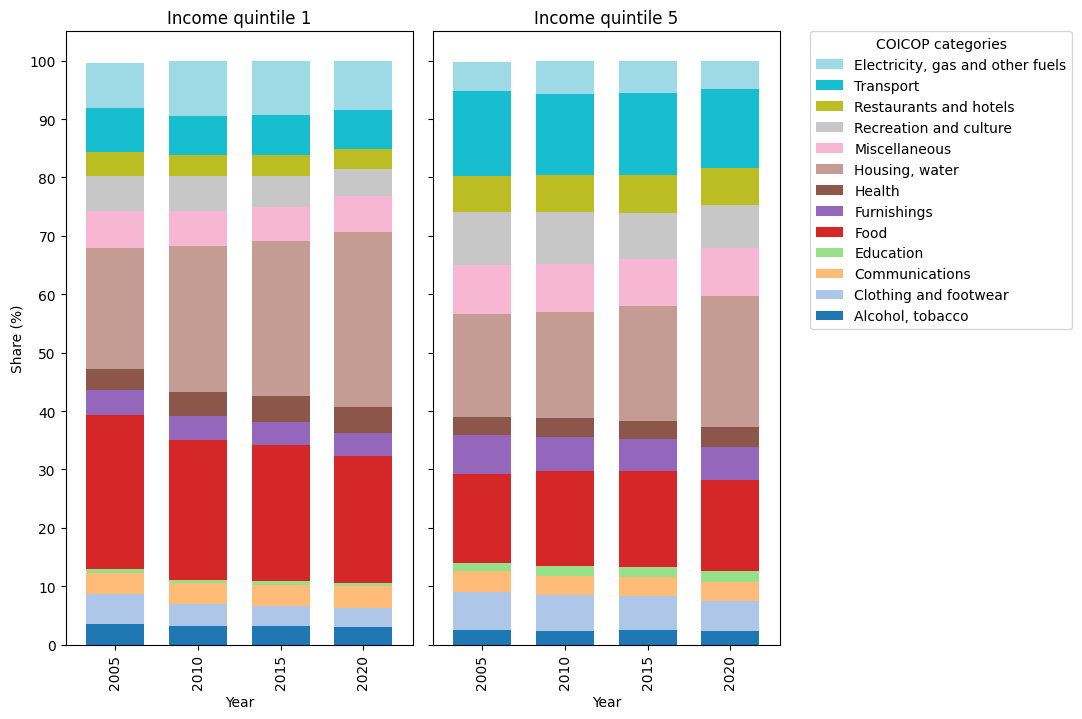

In [23]:
# --- 3) Plot both on the same figure with a single legend ---------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 7.3), sharey=True)

# Left: Q1
ax1 = axes[0]
df_q1.loc[2005:].plot(kind='bar', stacked=True, ax=ax1, colormap='tab20',  width=0.7)
ax1.set_title("Income quintile 1")
ax1.set_ylabel("Share (%)")
ax1.set_xlabel("Year")
ax1.legend_.remove()  # remove individual legend
ymax = ax1.get_ylim()[1]
ax1.set_yticks(np.arange(0, ymax + 1e-6, 10))  # 0, 10, 20, ... up to ymax

# Right: Q5
ax2 = axes[1]
df_q5.loc[2005:].plot(kind='bar', stacked=True, ax=ax2, colormap='tab20', width=0.7)
ax2.set_title("Income quintile 5")
ax2.set_ylabel("")  # share y-axis label from left
ax2.set_xlabel("Year")
ax2.legend_.remove()  # remove individual legend
ax2.set_yticks(ax1.get_yticks())

# Single shared legend (use handles/labels from ax1)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(reversed(handles), reversed(labels), title="COICOP categories",
           loc='center left', bbox_to_anchor=(1.01, 0.745))

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()